In [1]:
# Autoreload to accomodate script updates without restarting notebook
%load_ext autoreload
%autoreload 2
# Move to main directory of the Customer-Segmentation project
%cd ..

C:\Users\Vincent\Game-Revenant\Where-Shadows-Slumber\App-Store-Analysis


In [2]:
import pandas as pd
import sqlalchemy as sa
from pathlib import Path

# Pull interim data from SQLite DB

DB_NAME = 'app-store'
e = sa.create_engine('sqlite:///./data/interim/app-store.sqlite')
query = '''
        SELECT *, 'action' AS genre FROM iosaction UNION
        SELECT *, 'adventure' FROM iosadventure UNION
        SELECT *, 'board' FROM iosboard UNION
        SELECT *, 'card' FROM ioscard UNION 
        SELECT *, 'casino' FROM ioscasino UNION
        SELECT *, 'casual' FROM ioscasual UNION
        SELECT *, 'family' FROM iosfamily UNION
        SELECT *, 'music' FROM iosmusic UNION
        SELECT *, 'puzzle' FROM iospuzzle UNION
        SELECT *, 'racing' FROM iosracing UNION
        SELECT *, 'rpg' FROM iosrpg UNION
        SELECT *, 'simulation' FROM iossimulation UNION
        SELECT *, 'sports' FROM iossports UNION 
        SELECT *, 'strategy'FROM iosstrategy UNION 
        SELECT *, 'trivia' FROM iostrivia UNION
        SELECT *, 'word' FROM iosword
        '''
apps = pd.read_sql_query(query, e)

In [3]:
apps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380969 entries, 0 to 380968
Data columns (total 20 columns):
age          380969 non-null object
age_copy     380969 non-null object
author       380690 non-null object
category     380969 non-null object
compat       380969 non-null object
desc         380969 non-null object
editor       1384 non-null object
iap          148075 non-null object
lang         380969 non-null object
list_rank    11006 non-null object
nrating      234417 non-null object
price        380896 non-null object
score        234417 non-null object
seller       380969 non-null object
size         380969 non-null object
stars        234417 non-null object
subtitle     121114 non-null object
support      380969 non-null object
title        380969 non-null object
genre        380969 non-null object
dtypes: object(20)
memory usage: 58.1+ MB


In [4]:
import re
import numpy as np

# age (categorical)
# Age rating for game. Dummy encoded.
# Categories are 4+, 9+, 12+, 17+

age_encoded = pd.get_dummies(apps['age'])
age_encoded.columns = ['age_' + col.replace('+','') for col in age_encoded.columns]
apps = pd.concat([apps, age_encoded], axis=1)
apps = apps.drop(columns=['age'])

# age_copy (str)
# Long string containing a variety information, including age rating, memory size, copyright information. 
# Was initially scraped to get the copyright year, to give estimate of release date. 
# Copyright year is not included frequently enough, however, so this category was dropped

apps = apps.drop(columns=['age_copy'])

# author (str)
# Author of game. Can be used to consolidate duplicate game titles

# category (categorical)
# Category of app. Data was scrapped from game storefront, so everything should be listed as 'Games'
# There are a few cases where this was not true (e.g. classified as 'Education', or 'Music')
# Only concerned with game releases, so we filter for these specifically

apps = apps[apps['category'] == 'Games']
apps = apps.drop(columns=['category'])

# compat (ordinal)
# Compatibility of the app. Interested primarily in the minimum OS release requirements. 
# There are 409 different OS version releases (including minor releases), so we confine our search to major software versions

# Very few cases don't contain compatibility information; filter these out
apps = apps.dropna(subset=['compat']) 
# All version requirements starts with the phrase, 'Requires iOS x.x. or later'. First filter for that phrase
apps['compat'] = apps['compat'].apply(lambda compat: re.findall(r'Requires\siOS\s\d+', compat)) 
# Pull out just the major iOS release version. 
apps['compat'] = apps['compat'].apply(lambda compat: int(re.findall(r'\d+', compat[0])[0]) if compat else None)
# Also filter out apps that are not on iOS (few Apple TV apps)
apps = apps.dropna(subset=['compat']) 

# desc (str)
# Description of app. May be interesting to analyze for keywords in the future.
# Out-of-scope for this analysis, so it's dropped

apps = apps.drop(columns=['desc'])

# editor (boolean)
# Indicates whether the game was notable enough to receive an 'Editor's Choice' or 'Editor's Note' designation
# These recognized games are on the front page most often, and the App Store will promote these apps particularly

apps['editor'] = apps['editor'].apply(lambda editor: True if editor else False)

# genre (categorical)
# Genre of game, based on the page on which the title was scrapped from. Dummy encoded
# Note that games can be a part of multiple genres
# This was assigned in the SQL code a previous cell. 

genre_encoded = pd.get_dummies(apps['genre'])
genre_encoded.columns = ['gen_' + col.lower() for col in genre_encoded.columns]
apps = pd.concat([apps, genre_encoded], axis=1)
apps = apps.drop(columns=['genre'])

# iap (boolean)
# Indicates whether the game contains in-app purchases

apps['iap'] = apps['iap'].replace('Offers In-App Purchases', True).fillna(False)

# lang (categorical)
# Languages the game is available in. Dummy encoded
# Hyperparameter 'thresh' limits the number of language categories based on popularity

# new category counts number of languages the game is available in
apps['lang_cnt'] = apps['lang'].apply(lambda lang: len(lang.split(', ')))

lang_encoded = apps['lang'].str.get_dummies(', ')
thresh = 0.05 * len(apps)
thresh_list = (lang_encoded.sum(axis=0) < thresh).to_list()
ind_drop = np.where(thresh_list)
lang_encoded = lang_encoded.drop(lang_encoded.columns[ind_drop], axis=1)
lang_encoded.columns = ['lang_' + col.replace(' ','_').lower() for col in lang_encoded.columns]

apps = pd.concat([apps, lang_encoded], axis=1)
apps = apps.drop(columns=['lang'])

# list_rank (boolean)
# Typically the rank of the game within a given category (assuming the game is ranked)
# Field is not strictly limited to rank: it can also contain hardware restrictions ('Only for Apple TV'). 
# Anticipated release dates can also be found in this field.
# Initially seemed like a promising predictive feature, but upon inspection of the data, the ranking system is not consistent.
# Games can appear in different genre pages, and be ranked in other genres. Value of rank is inconsistent as well.
# Due to the inconsistency of this metric, it was simplified into a boolean: ranked, or not

apps['list_rank'] = apps['list_rank'].fillna('').apply(lambda rank: True if re.findall(r'#', rank) else False)

# nrating (numeric)
# Number ratings the game received

apps['nrating'] = apps['nrating'].fillna('0.0') # account for games that haven't been rated
# In raw form, if the review count is over a thousand or a million, the abbreviation 'K' or 'M' is used
apps['in_K'] = apps['nrating'].apply(lambda nrating: True if re.findall(r'K', nrating) else False)
apps['in_M'] = apps['nrating'].apply(lambda nrating: True if re.findall(r'M', nrating) else False)
apps['nrating'] = apps['nrating'].apply(lambda nrating: float(re.findall(r'[\d\.]+', nrating)[0]))
apps['nrating'] = apps.apply(lambda app: 1e3*app['nrating'] 
                             if app['in_K'] == True 
                             else app['nrating'], axis=1)
apps['nrating'] = apps.apply(lambda app: 1e6*app['nrating'] 
                             if app['in_M'] == True 
                             else app['nrating'], axis=1)
apps = apps.drop(columns=['in_K', 'in_M'])

# price (numeric)
# Price of game

# we also drop a few cases (73) where a price wasn't listed
apps = apps.dropna(subset=['price'])
apps['price'] = apps['price'].apply(lambda price: float(re.findall(r'[\d\.]+', price)[0]) 
                                    if price != 'Free' 
                                    else 0.0)

# score (numeric)
# Mean score across all ratings. Games that have not been rated will have a NaN assigned in this field

apps['score'] = apps['score'].fillna(np.nan).apply(float)

# seller (str)
# Party that sells the game, usually same as author. Dropped in this project

apps = apps.drop(columns=['seller'])

# size (float)
# Size of game, in MB. Games that are in KB are rounded to 1.0 MB

apps['in_KB'] = apps['size'].apply(lambda nrating: True if re.findall(r'KB', nrating) else False)
apps['in_GB'] = apps['size'].apply(lambda nrating: True if re.findall(r'GB', nrating) else False)
apps['size'] = apps['size'].apply(lambda nrating: float(re.findall(r'[\d\.]+', nrating)[0]))
apps['size'] = apps.apply(lambda app: 1.0
                             if app['in_KB'] == True 
                             else app['size'], axis=1)
apps['size'] = apps.apply(lambda app: 1e3*app['size'] 
                             if app['in_GB'] == True 
                             else app['size'], axis=1)
apps = apps.drop(columns=['in_KB', 'in_GB'])

# stars (numerical)
# Rating breakdown for the game
# Split into multiple categories, one for each possible rating

apps['stars'] = apps['stars'].apply(lambda rating: re.findall(r'\d+', rating)
                                    if rating is not None 
                                    else [0, 0, 0, 0, 0])
apps['star5'] = apps['stars'].apply(lambda rating: float(rating[0]))
apps['star4'] = apps['stars'].apply(lambda rating: float(rating[1]))
apps['star3'] = apps['stars'].apply(lambda rating: float(rating[2]))
apps['star2'] = apps['stars'].apply(lambda rating: float(rating[3]))
apps['star1'] = apps['stars'].apply(lambda rating: float(rating[4]))
apps = apps.drop(columns=['stars'])

# subtitle (str)
# Subtitle of game, if it exists. 
# Could be useful in the future of keyword analysis, but dropped for now

apps = apps.drop(columns=['subtitle'])

# support (categorical)
# iOS supports features such as 'Family Center' and 'Game Center' which can augment a user's experience

# one-hot enocde supports category
supports_encoded = apps['support'].str.get_dummies(',')
supports_encoded.columns = ['sup_' + col.replace(' ','_').lower() for col in supports_encoded.columns]
apps = pd.concat([apps, supports_encoded], axis=1)
apps = apps.drop(columns=['support'])

# title (str)
# Title of game
# Games can be scrapped multiple times since they can be posted on multiple genre pages
# Title can be used to consolidate these duplicates

def agg_func(x):
    '''Dictate the aggregate function to apply based on the data object type

    param x: DataFrame groupby object
    '''
    if x.dtype in ('float64', 'object'):
        return x.mean()
    elif x.dtype in ('bool', 'uint8', 'int64'):
        return x.max()
    else:
        print('Unrecognized dtype!')

# Duplicate game titles can contain different rating and star values. These are will be averaged
# Boolean and integer values are dummy categories, so we mark as True/1 if so in at least one row
apps = apps.groupby(['title','author']).agg(agg_func).reset_index()


# Once date has been cleaned, we can save the data set to a DB
e = sa.create_engine('sqlite:///./data/processed/app-store-clean.sqlite')
apps.to_sql('ios', e, if_exists='replace')

In [5]:
e = sa.create_engine('sqlite:///./data/interim/app-store.sqlite')
apps = pd.read_sql_query('SELECT * FROM ios', e)
apps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195732 entries, 0 to 195731
Data columns (total 57 columns):
index                       195732 non-null int64
title                       195732 non-null object
author                      195732 non-null object
compat                      195732 non-null float64
editor                      195732 non-null int64
iap                         195732 non-null int64
list_rank                   195732 non-null int64
nrating                     195732 non-null float64
price                       195732 non-null float64
score                       119988 non-null float64
size                        195732 non-null float64
age_12                      195732 non-null int64
age_17                      195732 non-null int64
age_4                       195732 non-null int64
age_9                       195732 non-null int64
gen_action                  195732 non-null int64
gen_adventure               195732 non-null int64
gen_board                  

Data is heavily skewed, which will be a problem down the line. Most games are far from successful!

count    1.956360e+05
mean     6.536435e+02
std      1.787708e+04
min      0.000000e+00
25%      0.000000e+00
50%      1.000000e+00
75%      8.000000e+00
max      4.500000e+06
Name: nrating, dtype: float64

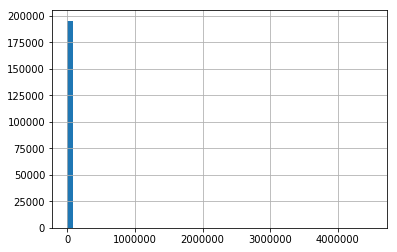

In [51]:
apps['nrating'].hist(bins=50)
apps['nrating'].describe()

CUt down the data set. Shadows has 175 reviews; lets aim for that at 50%

In [59]:
apps[apps['title']=='Where Shadows Slumber'][['title','nrating']]

,title,nrating
187663,Where Shadows Slumber,175.0


In [60]:
apps = apps[apps['nrating']>36]
apps['nrating'].describe()

count    2.559300e+04
mean     4.974343e+03
std      4.920964e+04
min      3.650000e+01
25%      7.100000e+01
50%      1.760000e+02
75%      7.255000e+02
max      4.500000e+06
Name: nrating, dtype: float64

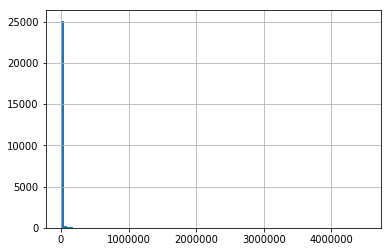

In [65]:
apps['nrating'].hist(bins=100)

In [75]:
pd.qcut(apps['nrating'], 5).value_counts()

(286.0, 1100.0]        5257
(61.2, 118.0]          5148
(36.499, 61.2]         5119
(118.0, 286.0]         5098
(1100.0, 4500000.0]    4971
Name: nrating, dtype: int64

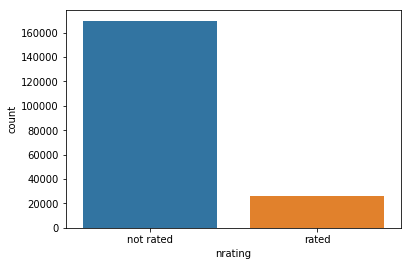

In [52]:
import seaborn as sns

bins = [-1, 35, apps['nrating'].max()+1]
labels = ['not rated', 'rated']
have_rating = pd.cut(apps['nrating'], bins=bins, labels=labels)
ax = sns.countplot(x=have_rating)

In [ ]:
apps[apps['nrating']>36][['score','nrating']].describe()

In [6]:
# Filter out games >= $60
# 96 games with exorbitant pricing, mostly by one developer, Andrew Kudrin, who prices all his games at $179.99
# Highest number of ratings in this price range is 3; most have 0
# Maybe the business model is to trick small kids into inadvertantly buying a poorly designed 3D animal game?
apps = apps[apps['price']<60]



In [7]:
apps[(apps['nrating']>100) & (apps['nrating']<2e3)]['nrating'].hist(bins=100)

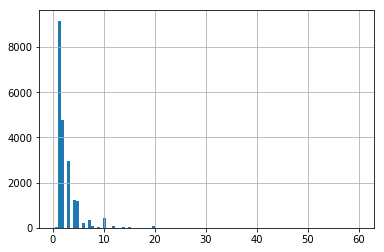

In [8]:
apps[apps['price']>0]['price'].hist(bins=100)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000007D401F60>,
      dtype=object)

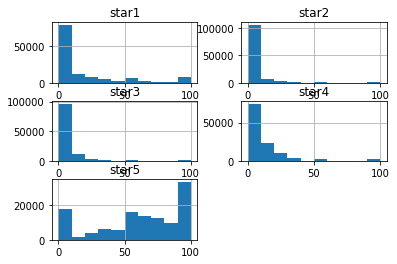

In [9]:
apps[apps['nrating']>0][['star1','star2','star3','star4','star5']].hist()

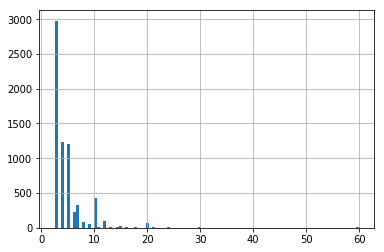

In [10]:
apps[apps['price']>2]['price'].hist(bins=100)

In [11]:
apps[apps['price']==59.99][['title','author']]

,title,author
7454,Agnes Bernauer :: SC,Enigram Games
14572,Aunt Mary Ann :: SC,Enigram Games
18396,BankoHallen,Frank Kalhoj
56540,Double Klondike :: SC,Enigram Games
60756,Eight Off :: SC,Enigram Games
76881,GOTO Bridge 19,GOTO Games
99091,Kangaroo :: SC,Enigram Games
121516,Napoleon's Square One :: SC,Enigram Games
148001,Russian Solitaire :: SC,Enigram Games
161588,Spider Two Suits :: SC,Enigram Games


In [34]:
apps[apps['nrating']>36][['score','nrating']].describe()

,score,nrating
count,25593.000000,2.559300e+04
mean,4.254652,4.974343e+03
std,0.548423,4.920964e+04
min,1.000000,3.650000e+01
25%,4.050000,7.100000e+01
50%,4.400000,1.760000e+02
75%,4.600000,7.255000e+02
max,5.000000,4.500000e+06
